**Importing Packages**

In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from geopy.geocoders import Nominatim
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot
import plotly.express as px
import string
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
#import requests 
#from bs4 import BeautifulSoup
#import re
#import plotly.io as pio
#pio.renderers.default = "svg"
#color = sns.color_palette()


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


**Defining the UEFA Champions League season info**

In [2]:
#url of last five seasons to retrieve data from
url = ['https://en.wikipedia.org/wiki/2018%E2%80%9319_UEFA_Champions_League', 
       'https://en.wikipedia.org/wiki/2017%E2%80%9318_UEFA_Champions_League',
       'https://en.wikipedia.org/wiki/2016%E2%80%9317_UEFA_Champions_League', 
       'https://en.wikipedia.org/wiki/2015%E2%80%9316_UEFA_Champions_League', 
       'https://en.wikipedia.org/wiki/2014%E2%80%9315_UEFA_Champions_League']
url_group=['https://en.wikipedia.org/wiki/2018%E2%80%9319_UEFA_Champions_League_group_stage',
                'https://en.wikipedia.org/wiki/2017%E2%80%9318_UEFA_Champions_League_group_stage',
                'https://en.wikipedia.org/wiki/2016%E2%80%9317_UEFA_Champions_League_group_stage',
                'https://en.wikipedia.org/wiki/2015%E2%80%9316_UEFA_Champions_League_group_stage', 
                'https://en.wikipedia.org/wiki/2014%E2%80%9315_UEFA_Champions_League_group_stage']
#start and end index of group stage tables in the above urls
group_table_index = [{'23' : '31'}, {'15' : '23'}, {'15' : '23'}, {'15' : '23'}, {'14' : '22'}]
group_table_index_1 = [8,10,7,7,7]
season = ['2018-19', '2017-18', '2016-17', '2015-16', '2014-15']

**Defining pre-processing and cleaning functions**

In [3]:
teams_league_dict = {'1899 Hoffenheim': 'German Bundesliga', 'AEK Athens': 'Super League Greece',
                     'APOEL': 'Cyprus First Division','Ajax': 'Dutch Eredivisie',
                     'Anderlecht': 'Belgian First Division A',
                     'Arsenal': 'English Premier League','Astana': 'Kazakhstan Premier League',
                     'Athletic Bilbao': 'Spanish La Liga','Atlético Madrid': 'Spanish La Liga',
                     'BATE Borisov': 'Belarusian Premier League',
                     'Barcelona': 'Spanish La Liga', 'Basel': 'Swiss Super League',
                     'Bayer Leverkusen': 'German Bundesliga',
                     'Bayern Munich': 'German Bundesliga','Benfica': 'Portuguese Primeira Liga',
                     'Beşiktaş': 'Turkish Süper Lig','Borussia Dortmund': 'German Bundesliga',
                     'Borussia Mönchengladbach': 'German Bundesliga',
                     'CSKA Moscow': 'Russian Premier League', 'Celtic': 'Scottish Premiership',
                     'Chelsea': 'English Premier League',
                     'Club Brugge': 'Belgian First Division A','Copenhagen': 'Danish Superliga',
                     'Dinamo Zagreb': 'Croatian First Football League',
                     'Dynamo Kyiv': 'Ukrainian Premier League','Feyenoord': 'Dutch Eredivisie',
                     'Galatasaray': 'Turkish Süper Lig', 'Gent': 'Belgian First Division A',
                     'Inter Milan': 'Italian Serie A', 'Juventus': 'Italian Serie A',
                     'Lyon': 'France Ligue 1','Maccabi Tel Aviv': 'Israeli Premier League',
                     'Malmö': 'Swedish Allsvenskan','Malmö FF': 'Swedish Allsvenskan',
                     'Manchester City': 'English Premier League',
                     'Manchester United': 'English Premier League','Maribor': 'Slovenian PrvaLiga',
                     'Monaco': 'France Ligue 1','Napoli': 'Italian Serie A',
                     'Olympiacos': 'Super League Greece','PSV Eindhoven': 'Dutch Eredivisie',
                     'Paris Saint-Germain': 'France Ligue 1',
                     'Porto': 'Portuguese Primeira Liga','Qarabağ': 'Azerbaijan Premier League',
                     'RB Leipzig': 'German Bundesliga', 'Real Madrid': 'Spanish La Liga',
                     'Red Star Belgrade': 'Serbian SuperLiga', 'Roma': 'Italian Serie A',
                     'Rostov': 'Russian Premier League','Schalke 04': 'German Bundesliga',
                     'Shakhtar Donetsk': 'Ukrainian Premier League',
                     'Spartak Moscow': 'Russian Premier League',
                     'Sporting CP': 'Portuguese Primeira Liga','Sevilla': 'Spanish La Liga',
                     'Tottenham Hotspur': 'English Premier League', 'Valencia':'Spanish La Liga',
                     'Viktoria Plzeň': 'Czech First League', 'Wolfsburg': 'German Bundesliga',
                     'Young Boys': 'Swiss Super League',
                     'Zenit Saint Petersburg': 'Russian Premier League',
                     'Legia Warsaw': 'Polish Ekstraklasa',
                     'Leicester City': 'English Premier League',
                     'Liverpool': 'English Premier League',
                     'Lokomotiv Moscow': 'Russian Premier League',
                     'Ludogorets Razgrad': 'Bulgarian First League',}

def intinstr(s):
    return re.findall(r'\d+', str(s))[0]

def group_home_goals_f(s):
    s = str(s).split('–')
    if(len(s)==2):
        return int(s[0])
    else:
        return 0
    
def group_home_goals_a(s):
    s = str(s).split('–')
    if(len(s)==2):
        return int(s[1])
    else:
        return 0     
    
def group_away_goals_f(df):
    gagf = []
    for i,r in df.iterrows():
        final_val = []
        x = r['Team']
        val = df[x].tolist()
        for a in val:
            a = str(a).split('–')
            if(len(a)==2):
                final_val.append(int(a[1]))
            else:
                final_val.append(0)
        gagf.append(sum(final_val))
    return gagf

def group_away_goals_a(df):
    gaga = []
    for i,r in df.iterrows():
        final_val = []
        x = r['Team']
        val = df[x].tolist()
        for a in val:
            a = str(a).split('–')
            if(len(a)==2):
                final_val.append(int(a[0]))
            else:
                final_val.append(0)
        gaga.append(sum(final_val))
    return gaga

def qualified_round_16(s):
    if(int(s)==1 or int(s)==2):
        return 1
    else:
        return 0
    
def location(s):
    # Create geo_locator object instance
    geo_locator = Nominatim()
    loc = ''
    if(str(s) == 'Juventus'):
        s = 'Turin, Italy'
    elif(str(s) == 'Real Madrid'):
        s = 'Madrid, Spain'
    elif(str(s) == 'Manchester United'):
        s = 'Old Trafford, England'
    elif(str(s) == 'Benfica'):
        s = 'Lisbon, Portugal'
    elif(str(s) == 'Sporting CP'):
        s = 'Lisbon, Portugal'
    elif(str(s) == 'Celtic'):
        s = 'Glasgow, United Kingdom'
    elif(str(s) == 'Inter Milan'):
        s = 'Milan, Italy'
    elif(str(s) == 'Ajax'):
        s = 'Amsterdam, Netherlands'
    elif(str(s) == 'Young Boys'):
        s = 'Bern, Switzerland'
    elif(str(s) == 'Olympiacos'):
        s = 'Pireas, Greece'
    elif(str(s) == 'Red Star Belgrade'):
        s = 'Belgrade, Serbia'
    elif(str(s) == 'Viktoria Plzeň'):
        s = 'Pilsen, Czechia'
    elif(str(s) == '1899 Hoffenheim'):
        s = 'Hoffenheim, Sinsheim, Germany'
    try:
        loc = geo_locator.geocode(str(s))
    except:
        pass
    if(loc):
        return loc.latitude, loc.longitude
    else:
        return None, None  

**Preparing Data for group stage**

In [4]:
concat_group_tables = []
teams = []

for i, u in enumerate(url):       #iterating through all urls

    tables = pd.read_html(url[i]) #reading all tables from url
    group_tables = []

    start = int(list(group_table_index[i].keys())[0]) #retrieving start index of group stage table
    end = int(list(group_table_index[i].values())[0]) #retrieving end index of group stage table
    year = season[i]                                  #retrieving season 

    for df in tables[start:end]:

        #new_header = df.iloc[0] #grab the first row for the header
        #df = df[1:] #take the data less the header row
        #df.columns = new_header #set the header row as the df header
        
        df.rename(columns = {'Team[ vte ]' : 'Team', 'Unnamed: 11' : 'Garbage'}, inplace=True)
        
        #renaming short form names of teams
        team_names_col = df.columns.tolist()[-4:]
        team_names = df.loc[:,'Team'].values.tolist()
        team_names_col_replace = {}
        for i, te in enumerate(team_names_col):
            team_names_col_replace[te] = team_names[i]
        df.rename(columns = team_names_col_replace, inplace=True)  
        
        df.reset_index(inplace=True)
        #df.iloc[1,12:] = df.iloc[1,12:].shift(1)
        
        #Enriching and cleaning data
        df['Pts'] = df['Pts'].apply(intinstr)
        df.drop(columns = ['index', 'Garbage', 'Qualification'], inplace=True) #dropping columns
        df['Season'] = year
        df['HGF'] = df.iloc[:,10].apply(group_home_goals_f) + df.iloc[:,11].apply(group_home_goals_f)+ df.iloc[:,12].apply(group_home_goals_f)+ df.iloc[:,13].apply(group_home_goals_f)
        df['AGF'] = group_away_goals_f(df)
        df['HGA'] = df.iloc[:,10].apply(group_home_goals_a) + df.iloc[:,11].apply(group_home_goals_a) + df.iloc[:,12].apply(group_home_goals_a)+ df.iloc[:,13].apply(group_home_goals_a)
        df['AGA'] = group_away_goals_a(df)
        df['HGD'] = df['HGF'] - df['HGA']
        df['AGD'] = df['AGF'] - df['AGA']
        df['Round_16'] = df['Pos'].apply(qualified_round_16)
        df['League'] = df['Team'].map(teams_league_dict)
        df['Pld'] = df['Pld'].astype(int)
        df['Pts'] = df['Pts'].astype(int)
        df['GF'] = df['GF'].astype(int)
        df['GA'] = df['GA'].astype(int)
        df['GD'] = df['GF'] - df['GA']
        df['latitude'],df['longitude'] = zip(*df['Team'].apply(location))
        teams.extend(df['Team'].tolist())
        group_tables.append(df)

    concat_group_tables.append(group_tables)

#creating a dataframe of all unique teams from five UCL seasons and their leagues
df_teams = pd.DataFrame()
df_teams['Team'] = list(set(teams))
df_teams.sort_values(by=['Team'], inplace=True)
df_teams = df_teams.reset_index(drop=True)
df_teams['League'] = df_teams['Team'].map(teams_league_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: DeprecationWarning:

Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.



In [5]:
group_stage_yearly = []
for temp in concat_group_tables:
    temp_list = [df[['Pos', 'Team', 'Pld', 'W', 'D', 'L', 'GF', 'GA', 'GD', 
                     'Pts', 'Season', 'HGF','AGF', 'HGA', 'AGA', 'HGD', 'AGD', 'Round_16', 
                     'League', 'latitude', 'longitude']] for df in temp]
    group_stage_yearly.append(pd.concat(temp_list).reset_index(drop=True))

In [6]:
group_stage_yearly[0].head()

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,...,HGF,AGF,HGA,AGA,HGD,AGD,Round_16,League,latitude,longitude
0,1,Borussia Dortmund,6,4,1,1,10,2,8,13,...,7,3,0,2,7,1,1,German Bundesliga,51.477224,7.373194
1,2,Atlético Madrid,6,4,1,1,9,6,3,13,...,7,2,1,5,6,-3,1,Spanish La Liga,40.399810,-3.721210
2,3,Club Brugge,6,1,3,2,6,5,1,6,...,1,5,2,3,-1,2,0,Belgian First Division A,51.208553,3.226772
3,4,Monaco,6,0,1,5,2,14,-12,1,...,1,1,8,6,-7,-5,0,France Ligue 1,43.732349,7.427683
4,1,Barcelona,6,4,2,0,14,5,9,14,...,7,7,1,4,6,3,1,Spanish La Liga,41.382894,2.177432


In [ ]:
'''@interact
def bar_plot_3(season=[0,1,2,3,4]):

    fig, axes = plt.subplots(figsize=(16,16),nrows=2, ncols=2)

    plt.subplots_adjust(wspace = 0.5)

    ax1 = group_stage_yearly[season].sort_values(by=['Pts'], ascending=0)[0:10].plot(ax=axes[0,0],kind='barh', width=0.75, x='Team',y=['Pts'])
    ax1.invert_yaxis()
    #ax = group_stage_yearly[0].sort_values(by=['Pts'], ascending=0)[0:10].plot(kind='barh',x='Team',y=['Pts','GF','GA'])

    ax2 = group_stage_yearly[season].sort_values(by=['GF'], ascending=0)[0:10].plot(ax=axes[0,1], kind='barh', width=0.75, x='Team',y=['GF'])
    ax2.invert_yaxis()

    ax3 = group_stage_yearly[season].sort_values(by=['GA'], ascending=1)[0:10].plot(ax=axes[1,0], kind='barh', width=0.75, x='Team',y=['GA'])
    ax3.invert_yaxis()

    ax3 = group_stage_yearly[season].sort_values(by=['GD'], ascending=0)[0:10].plot(ax=axes[1,1], kind='barh', width=0.75, x='Team',y=['GD'],)
    ax3.invert_yaxis()

    plt.show('png')'''

**Location of Teams in UEFA Champions League**

In [7]:
df_group_stage = (pd.concat(group_stage_yearly).reset_index(drop=True)) #concatenating all season data into one dframe

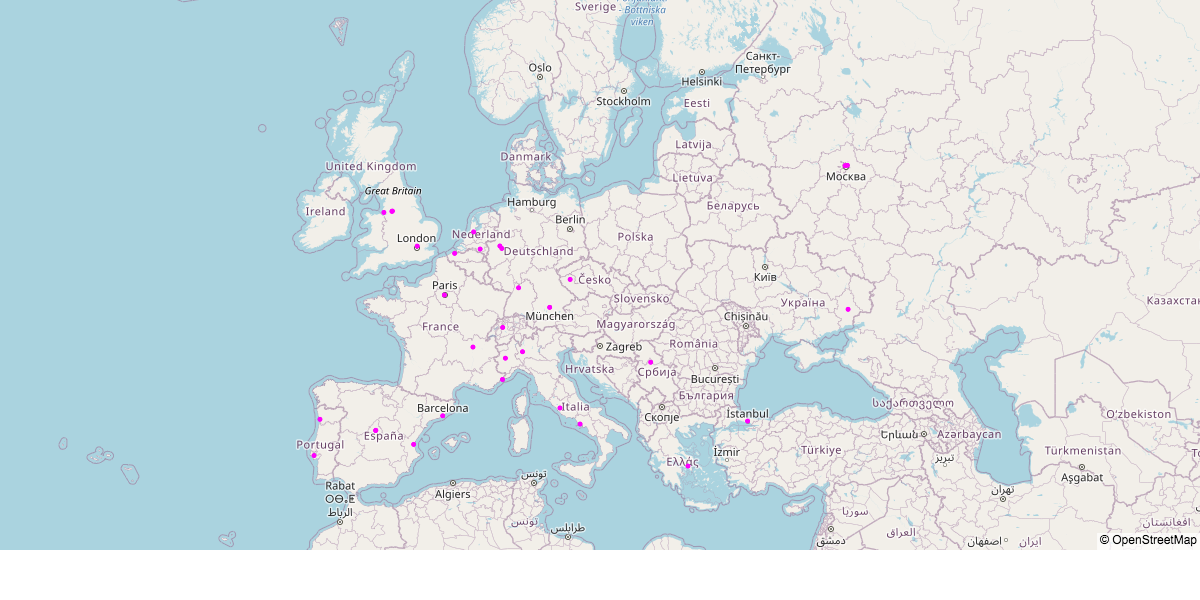

'@interact\ndef map_plot(season=season):\n\n    df_plot = df_group_stage[df_group_stage[\'Season\'] == season].reset_index(drop=True)\n    fig = px.scatter_mapbox(df_plot, lat="latitude", lon="longitude", hover_name="Team",color_discrete_sequence=["fuchsia"], zoom=3, height=300, center = {\'lat\':50, \'lon\':16})\n    fig.update_layout(mapbox_style="open-street-map")\n    fig.update_layout(height = 600, width = 1200, margin={"r":200,"t":0,"l":0,"b":50})\n    iplot(fig)'

In [8]:
#Note: To use inetractive mode just comment first block and uncomment next block of code

#First block
def map_plot(season='2018-19'):

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    fig = px.scatter_mapbox(df_plot, lat="latitude", lon="longitude", hover_name="Team",
                            color_discrete_sequence=["fuchsia"], zoom=3, 
                            height=300, center = {'lat':50, 'lon':16})
    
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(height = 600, width = 1200, margin={"r":0,"t":0,"l":0,"b":50})
    fig.show('png',height = 600, width = 1200)
    
map_plot()

#Second block
'''@interact
def map_plot(season=season):

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    fig = px.scatter_mapbox(df_plot, lat="latitude", lon="longitude", hover_name="Team",color_discrete_sequence=["fuchsia"], zoom=3, height=300, center = {'lat':50, 'lon':16})
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(height = 600, width = 1200, margin={"r":200,"t":0,"l":0,"b":50})
    iplot(fig)'''

**Exploring Teams Performance in Group Stage**

/anaconda3/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



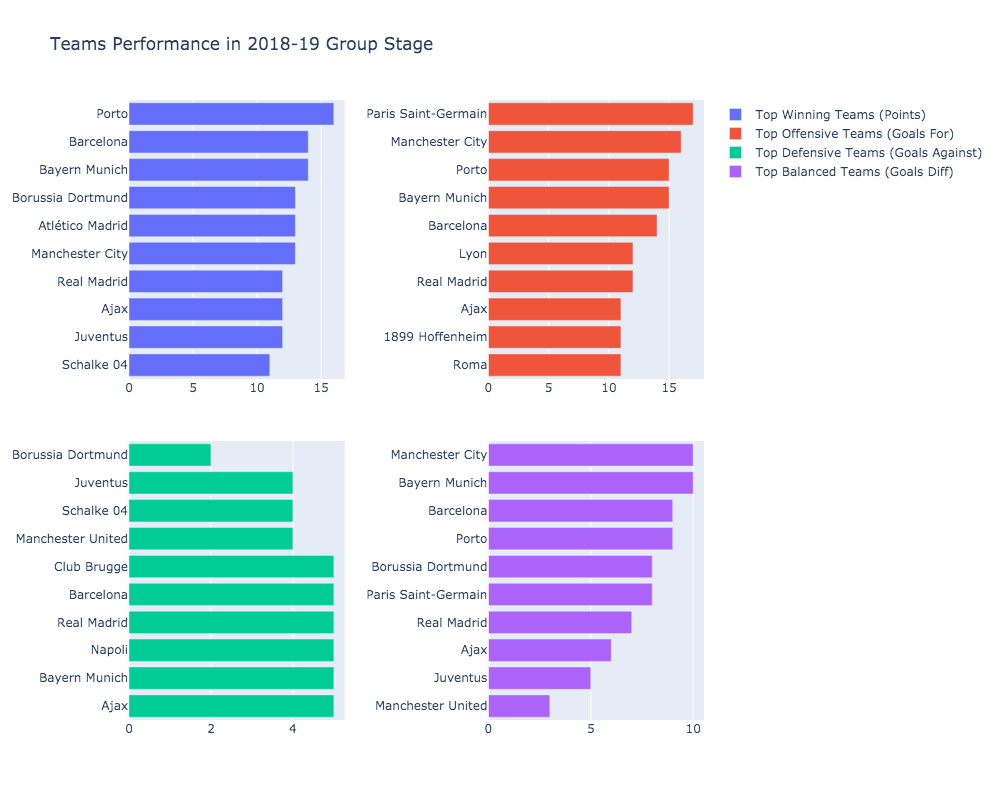

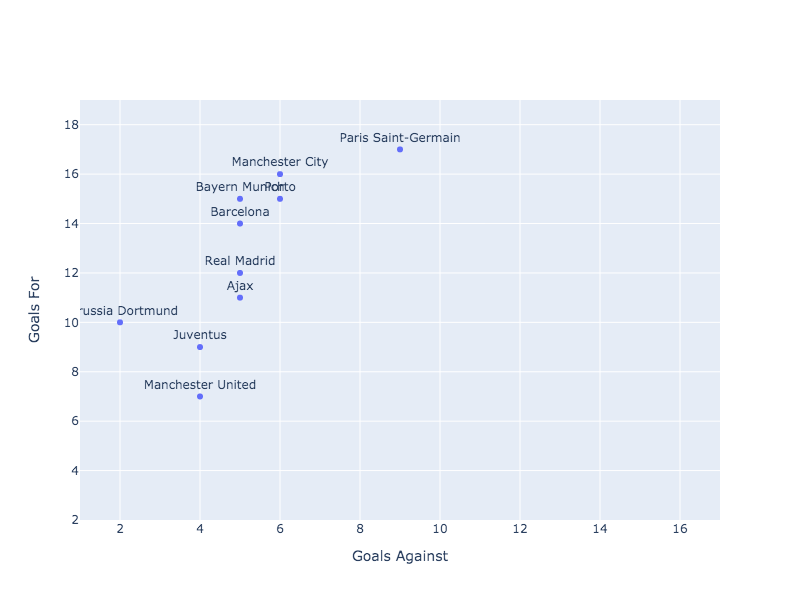

In [9]:
# Following interactive chart can be used to analyze multiple metrics(Points, Goals For, Goals Against, Home, Away etc.)
# to measure teams performances in different UCL seasons/year 

#Note: To use inetractive mode just comment first block and uncomment next block of code

#First block
def bar_plot_1(season='2018-19', performance = 'Overall', top = 10):
    
    if(performance == 'Overall'):
        metric = ['GF', 'GA', 'GD']
    elif(performance == 'Home'):
        metric = ['HGF', 'HGA', 'HGD']
    elif(performance == 'Away'):
        metric = ['AGF', 'AGA', 'AGD']

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    
    trace1 = go.Bar(y = df_plot.sort_values(by=['Pts'], ascending=False).reset_index(drop=True)
                    [0:top].sort_values(by=['Pts'], ascending=True).loc[:,'Team'], 
                    x = df_plot.sort_values(by=['Pts'],ascending=0).reset_index(drop=True)
                    [0:top].sort_values(by=['Pts'], ascending=True).loc[:,'Pts'],
                    name = 'Top Winning Teams (Points)', orientation='h')
    
    trace2 = go.Bar(y = df_plot.sort_values(by=[metric[0]], ascending=0).reset_index(drop=True)
                    [0:top].sort_values(by=[metric[0]], ascending=True).loc[:,'Team'],
                    x = df_plot.sort_values(by=[metric[0]], ascending=0).reset_index(drop=True)
                    [0:top].sort_values(by=[metric[0]], ascending=True).loc[:,metric[0]],
                    name = 'Top Offensive Teams (Goals For)', orientation='h')
    
    trace3 = go.Bar(y = df_plot.sort_values(by=[metric[1]], ascending=1).reset_index(drop=True)
                    [0:top].sort_values(by=[metric[1]], ascending=False).loc[:,'Team'],
                    x = df_plot.sort_values(by=[metric[1]], ascending=1).reset_index(drop=True)
                    [0:top].sort_values(by=[metric[1]], ascending=False).loc[:,metric[1]],
                    name = 'Top Defensive Teams (Goals Against)', orientation='h')
    
    trace4 = go.Bar(y = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)
                    [0:top].sort_values(by=[metric[2]], ascending=True).loc[:,'Team'],
                    x = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)
                    [0:top].sort_values(by=[metric[2]], ascending=True).loc[:,metric[2]],
                    name = 'Top Balanced Teams (Goals Diff)', orientation='h')
    
    trace5 = go.Scatter(y = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index
                        (drop=True)[0:top].sort_values(by=[metric[2]],
                        ascending=True).loc[:,metric[0]], x = df_plot.sort_values
                        (by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].
                        sort_values(by=[metric[2]], ascending=True).loc[:,metric[1]],
                        text = df_plot.sort_values(by=[metric[2]], ascending=0).
                        reset_index(drop=True)[0:top].sort_values(by=[metric[2]],
                        ascending=True).loc[:,'Team'], mode='markers+text',
                        textposition='top center', name = 'GF/GA')
    
    layout5 = go.Layout(yaxis=dict(range=[df_plot['GF'].min(),df_plot['GF'].max()+2]),
                        xaxis=dict(range=[df_plot['GA'].min()-1,df_plot['GA'].max()]))
    
    fig = tools.make_subplots(rows = 2, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.25)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 2)
    fig['layout'].update( height = 800, width = 1000, title = 'Teams Performance in ' +
                         season + ' Group Stage')
    #iplot(fig)
    fig.show('png',height = 800, width = 1000)
    
    fig1 = go.Figure()
    fig1.add_trace(trace5)
    fig1.update_layout(layout5,
                   xaxis_title='Goals Against',
                   yaxis_title='Goals For')
    #iplot(fig1)
    fig1.show('png',height = 600, width = 800)
    
bar_plot_1()

In [ ]:
#Second Block
'''@interact
def bar_plot_1(season=season, performance = ['Overall', 'Home', 'Away'], top = [5,10,20]):
    
    if(performance == 'Overall'):
        metric = ['GF', 'GA', 'GD']
    elif(performance == 'Home'):
        metric = ['HGF', 'HGA', 'HGD']
    elif(performance == 'Away'):
        metric = ['AGF', 'AGA', 'AGD']

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    
    trace1 = go.Bar(y = df_plot.sort_values(by=['Pts'], ascending=False).reset_index(drop=True)[0:top].sort_values(by=['Pts'], ascending=True).loc[:,'Team'], x = df_plot.sort_values(by=['Pts'], ascending=0).reset_index(drop=True)[0:top].sort_values(by=['Pts'], ascending=True).loc[:,'Pts'], name = 'Top Winning Teams (Points)', orientation='h')
    trace2 = go.Bar(y = df_plot.sort_values(by=[metric[0]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[0]], ascending=True).loc[:,'Team'], x = df_plot.sort_values(by=[metric[0]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[0]], ascending=True).loc[:,metric[0]], name = 'Top Offensive Teams (Goals For)', orientation='h')
    trace3 = go.Bar(y = df_plot.sort_values(by=[metric[1]], ascending=1).reset_index(drop=True)[0:top].sort_values(by=[metric[1]], ascending=False).loc[:,'Team'], x = df_plot.sort_values(by=[metric[1]], ascending=1).reset_index(drop=True)[0:top].sort_values(by=[metric[1]], ascending=False).loc[:,metric[1]], name = 'Top Defensive Teams (Goals Against)', orientation='h')
    trace4 = go.Bar(y = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,'Team'], x = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,metric[2]], name = 'Top Balanced Teams (Goals Diff)', orientation='h')
    trace5 = go.Scatter(y = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,metric[0]], x = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,metric[1]], text = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,'Team'], mode='markers+text', textposition='top center', name = 'GF/GA')
    layout5 = go.Layout(yaxis=dict(range=[df_plot['GF'].min(),df_plot['GF'].max()+2]), xaxis=dict(range=[df_plot['GA'].min()-1,df_plot['GA'].max()]))
    
    fig = tools.make_subplots(rows = 2, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.25)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 2)
    fig['layout'].update( height = 800, width = 1000, title = 'Teams Performance in ' + season + ' Group Stage')
    #iplot(fig)
    fig.show('png',height = 800, width = 1000)
    
    fig1 = go.Figure()
    fig1.add_trace(trace5)
    fig1.update_layout(layout5, title='Goals For Vs Goals Against',
                   xaxis_title='GA',
                   yaxis_title='GF')
    iplot(fig1)'''

**Exploring Country/Leagues Performance in Group Stage**

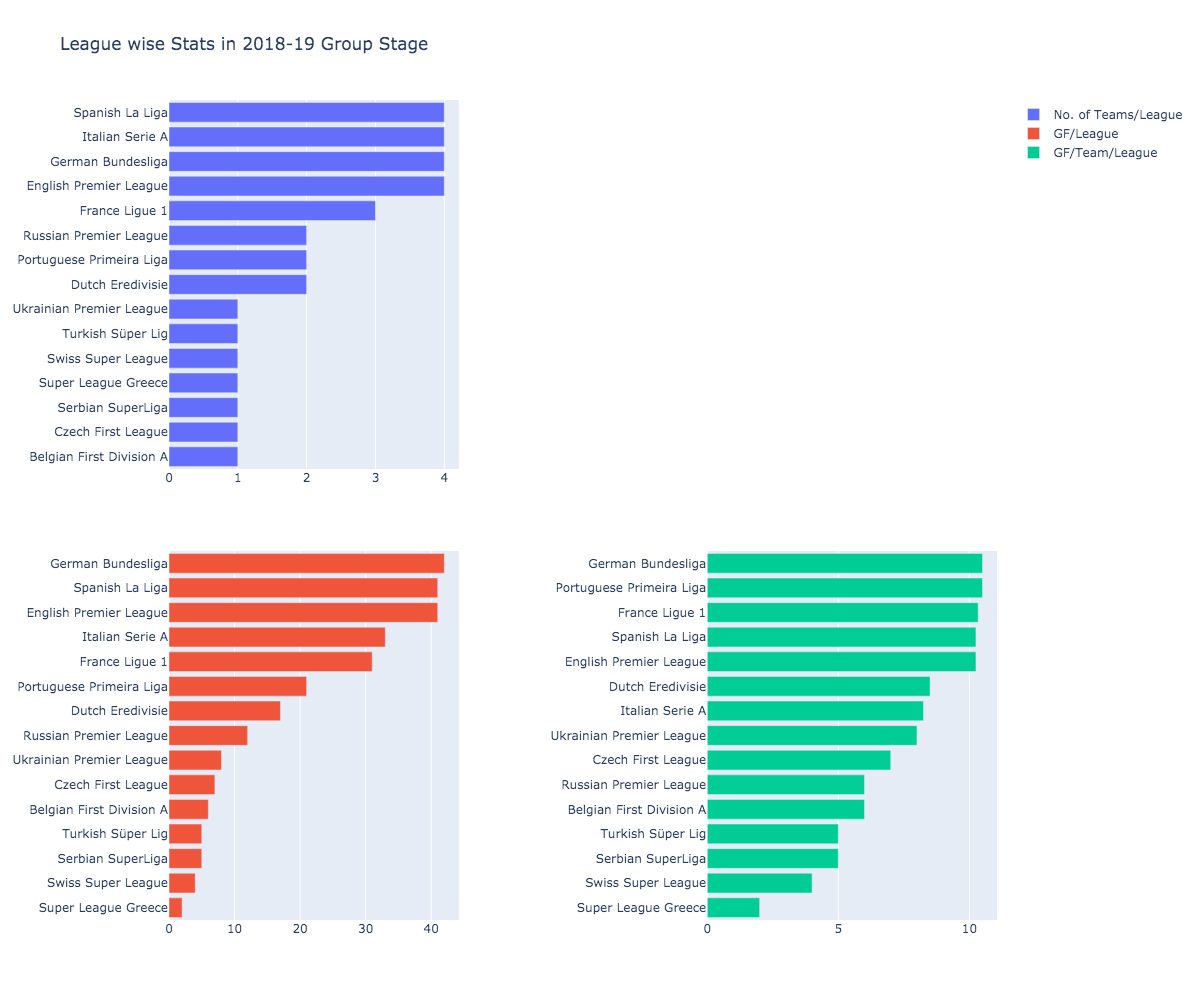

In [10]:
# Following interactive chart can be used to analyze multiple metrics(Goals For, Goals Against, etc.)
# to measure League/Country performances from different UCL seasons/year

#Note GF: Goals scored For
#     GA: Goals scored Against
#     GD: Goal Difference  

#Note: To use inetractive mode just comment first block and uncomment next block of code

#First block
def bar_plot_2(season='2018-19', metric = 'GF'):
    

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    
    df_plot_group = df_plot.groupby(['League']).size().reset_index(name='count').sort_values(
                        by=['count'])
    
    df_plot_group_gf = df_plot[['League', metric]].groupby(
                        ['League']).sum().reset_index().sort_values(by=[metric])
    
    df_plot_group_gf_avg = pd.merge(df_plot_group, df_plot_group_gf, on = 'League')
    df_plot_group_gf_avg[metric+'_Avg'] = df_plot_group_gf_avg[metric]/df_plot_group_gf_avg['count']
    df_plot_group_gf_avg.sort_values(by = [metric + '_Avg'], inplace = True)
       
    trace1 = go.Bar(y = df_plot_group['League'], x = df_plot_group['count'], 
                    name = 'No. of Teams/League',
                    orientation = 'h')
    
    trace2 = go.Bar(y = df_plot_group_gf['League'], x = df_plot_group_gf[metric], 
                    name = metric + '/League',
                    orientation='h')
    
    trace3 = go.Bar(y = df_plot_group_gf_avg['League'], x = df_plot_group_gf_avg[metric + '_Avg'],
                    name = metric + '/Team/League', orientation='h')
    
    fig = tools.make_subplots(rows = 2, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.3)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 2, 1)
    fig.append_trace(trace3, 2, 2)
    
    fig['layout'].update(height = 1000, width = 1200, title = 'League wise Stats in ' 
                         + season +  ' Group Stage')
    
    fig.show('png',height = 1000, width = 1200)
    
bar_plot_2()

In [ ]:
#Second Block
'''@interact
def bar_plot_2(season=season, metric = ['GF', 'GA', 'GD']):
    

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    df_plot_group = df_plot.groupby(['League']).size().reset_index(name='count').sort_values(by=['count'])
    df_plot_group_gf = df_plot[['League', metric]].groupby(['League']).sum().reset_index().sort_values(by=[metric])
    df_plot_group_gf_avg = pd.merge(df_plot_group, df_plot_group_gf, on = 'League')
    df_plot_group_gf_avg[metric + '_Avg']  = df_plot_group_gf_avg[metric] / df_plot_group_gf_avg['count']
    df_plot_group_gf_avg.sort_values(by = [metric + '_Avg'], inplace = True)
       
    trace1 = go.Bar(y = df_plot_group['League'], x = df_plot_group['count'], name = 'No. of Teams/League', orientation = 'h')
    trace2 = go.Bar(y = df_plot_group_gf['League'], x = df_plot_group_gf[metric], name = metric + '/League', orientation='h')
    trace3 = go.Bar(y = df_plot_group_gf_avg['League'], x = df_plot_group_gf_avg[metric + '_Avg'], name = metric + '/Team/League', orientation='h')
    
    fig = tools.make_subplots(rows = 2, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.3)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 2, 1)
    fig.append_trace(trace3, 2, 2)
    fig['layout'].update(height = 800, width = 950, title = 'League wise Stats in ' + season +  ' Group Stage')
    iplot(fig)'''

**Exploring Season Stats in Group Stage**  

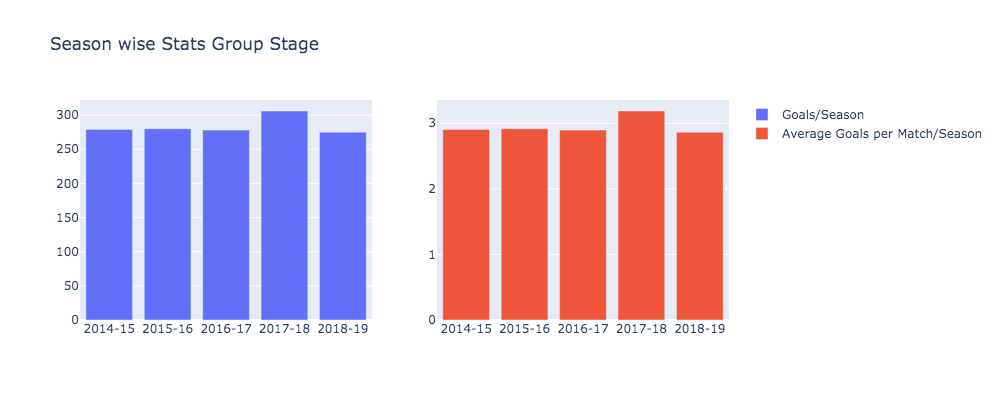

In [11]:
def bar_plot_3():
    
    total_matches = 96
    df_plot = df_group_stage[['Season','GF']].groupby(['Season']).sum().reset_index()
    df_plot['Avg_Goals'] = df_plot['GF']/total_matches
      
    trace1 = go.Bar(x = df_plot['Season'], y = df_plot['GF'], name = 'Goals/Season')
    trace2 = go.Bar(x = df_plot['Season'], y = df_plot['Avg_Goals'], 
                    name = 'Average Goals per Match/Season')
   
    fig = tools.make_subplots(rows = 1, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.1)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig['layout'].update(height = 400, width = 1000, title = 'Season wise Stats Group Stage')
    fig.show('png',height = 400, width = 1000)

bar_plot_3()

**Preparing goals data w.r.t. players**

In [13]:
df_players = pd.DataFrame()
for i,url in enumerate(url_group):
    
    tables = pd.read_html(url_group[i])     #reading all tables from url
    initial = group_table_index_1[i]              #reading initial index of group stage matches
    seas = season[i]                              #reading season/year
    index_list = []
    for i in range(8):
        index_list.append({initial:initial+12})
        initial = initial+13
        
    total_goals = []
    groups = list(string.ascii_uppercase)[0:8]     #creating list of 8 groups -> A-H
    for i in range(8):

        group = groups[i]                          #group of match
        start = int(list(index_list[i].keys())[0]) #retrieving start index 
        end = int(list(index_list[i].values())[0]) #retrieving end index

        final_df = pd.DataFrame()
        goals = []
        for j in range(start,end):

            #Preparing data - cleaning, manipulation, enriching
            goals_temp1 = tables[j].iloc[:,0].values.tolist()
            goals_temp1 = [g for g in goals_temp1 if g == g] #removing nan values
            goals_temp1 = [g.replace(u'\xa0', '').replace(u',', '').replace(u'+', '.')
                           .replace(u'(o.g.)', '').replace(u'(pen.)', '') for g in goals_temp1]
            
            goals_temp1 = [g.split("'") for g in goals_temp1]
            goals_temp1 = [j for g in goals_temp1 for j in g if len(j)>0]
            goals_temp1 = [g.lstrip().rstrip() for g in goals_temp1]
            for a,b in enumerate(goals_temp1):
                if(goals_temp1[a].isdigit()):
                    goals_temp1[a] = goals_temp1[a-1].split(' ')[0] + ' ' + goals_temp1[a]

            goals_temp2 = tables[j].iloc[:,2].values.tolist()
            goals_temp2 = [g for g in goals_temp2 if g == g] #removing nan values
            goals_temp2 = [g.replace(u'\xa0', '').replace(u',', '').replace(u'+', '.')
                           .replace(u'(o.g.)', '').replace(u'(pen.)', '') for g in goals_temp2]
            
            goals_temp2 = [g.split("'") for g in goals_temp2]
            goals_temp2 = [j for g in goals_temp2 for j in g if len(j)>0]
            goals_temp2 = [g.lstrip().rstrip() for g in goals_temp2]
            for a,b in enumerate(goals_temp2):
                if(goals_temp2[a].isdigit()):
                    goals_temp2[a] = goals_temp2[a-1].split(' ')[0] + ' ' + goals_temp2[a]
        
            if(len(goals_temp1)>0):
                goals_temp1 = [tables[j].columns.tolist()[0] +':'+ str(g) for g in goals_temp1]
            if(len(goals_temp2)>0):
                goals_temp2 = [tables[j].columns.tolist()[2] +':'+ str(g) for g in goals_temp2] 

            goals_temp1.extend(goals_temp2)
            goals_temp = goals_temp1        
            goals_temp = [str(group) + ':' + g for g in goals_temp]

            goals.extend(goals_temp)

        total_goals.extend(goals)
    
    #creating dataframe to store processed data
    final_df = pd.DataFrame(total_goals, columns=['data'])
    final_df['Group'] = final_df['data'].str.split(':', expand = True)[0]
    final_df['Team'] = final_df['data'].str.split(':', expand = True)[1]
    final_df['Player'] = ''
    final_df['Time scored'] = ''
    final_df['Season'] = seas
    for i,r in final_df.iterrows():
        raw = r['data'].split(':')[2].split(' ')
        #print(raw)
        if(len(raw)==2):
            final_df.loc[i,'Player'] = raw[0]
            final_df.loc[i,'Time scored'] = raw[1]        
        else:
            final_df.loc[i,'Player'] = ' '.join(raw[0:-1])
            final_df.loc[i,'Time scored'] = raw[-1]

    final_df.drop(columns=['data'], inplace = True)
    final_df = final_df[~ (final_df['Player'] == '')].reset_index(drop=True)

    df_players = df_players.append(final_df)

In [14]:
df_players.head(5)

,Group,Team,Player,Time scored,Season
0,A,Borussia Dortmund,Pulisic,85,2018-19
1,A,Monaco,Grandsir,18,2018-19
2,A,Atlético Madrid,Costa,31,2018-19
3,A,Atlético Madrid,Giménez,45.1,2018-19
4,A,Atlético Madrid,Griezmann,28,2018-19


**Exploring Players Performance in Group Stage**

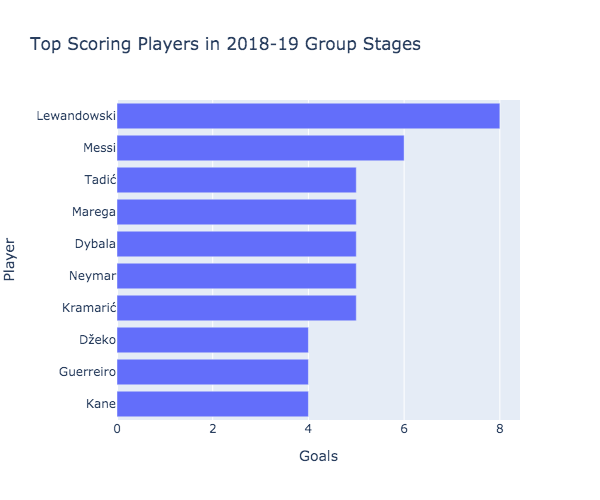

In [15]:
# Following interactive chart can be used to analyze players performances in different UCL seasons/year 

#Note: To use inetractive mode just comment first block and uncomment next block of code

#First block
def bar_plot_4(season='2018-19', top = 10):
    

    df_plot = df_players[df_players['Season'] == season].reset_index(drop=True)
    df_plot = df_plot.groupby(['Player']).size().reset_index(name='Goals').sort_values(by=['Goals'], 
                    ascending = 0).reset_index(drop=True)
    
    fig1 = go.Figure()
    trace1 = go.Bar(y = df_plot[0:top].sort_values(by=['Goals'], ascending=True).loc[:,'Player'],
                    x = df_plot[0:top].sort_values(by=['Goals'], ascending=True).loc[:,'Goals'],
                    name = 'Top Scoring Player', orientation='h' )
    
    fig1.add_trace(trace1)
    fig1.update_layout(title = 'Top Scoring Players in ' + str(season) + ' Group Stages',
                       xaxis_title='Goals', yaxis_title='Player')
    fig1.show('png',height = 500, width = 600)
    
bar_plot_4()

In [ ]:
#Second block
'''@interact
def bar_plot_4(season=season, top = [5,10,20]):
    

    df_plot = df_players[df_players['Season'] == season].reset_index(drop=True)
    df_plot = df_plot.groupby(['Player']).size().reset_index(name='Goals').sort_values(by=['Goals'], ascending = 0).reset_index(drop=True)
    
    fig1 = go.Figure()
    trace1 = go.Bar(y = df_plot[0:top].sort_values(by=['Goals'], ascending=True).loc[:,'Player'], x = df_plot[0:top].sort_values(by=['Goals'], ascending=True).loc[:,'Goals'], name = 'Top Scoring Player', orientation='h' )
    fig1.add_trace(trace1)
    fig1.update_layout(title = 'Top Scoring Players in ' + str(season) + ' Group Stages', xaxis_title='Goals', yaxis_title='Player')
    iplot(fig1)'''

**Comparing two best players - Cristiano Ronaldo and Lionel Messi in UCL - Group Stages**

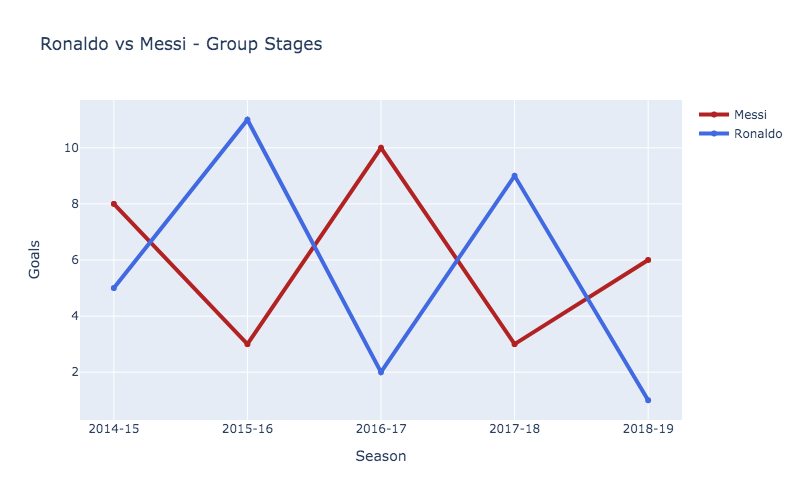

In [16]:
# Following interactive chart can be used to analyze players performances in different UCL seasons/year 

#Note: To use inetractive mode just comment first block and uncomment next block of code

#First block
def bar_plot_5():
    

    df_messi = df_players[df_players['Player'] == 'Messi'].reset_index(drop=True)
    df_messi = df_messi.groupby(['Season']).size().reset_index(name='Goals').sort_values(by=
                    ['Season'], ascending = 1).reset_index(drop=True)
    
    df_ronaldo = df_players[df_players['Player'] == 'Ronaldo'].reset_index(drop=True)
    df_ronaldo = df_ronaldo.groupby(['Season']).size().reset_index(name='Goals').sort_values(by=
                    ['Season'], ascending = 1).reset_index(drop=True)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_messi['Season'], y= df_messi['Goals'], name='Messi',
                         line=dict(color='firebrick', width=4)))
    
    fig.add_trace(go.Scatter(x=df_ronaldo['Season'], y= df_ronaldo['Goals'], name='Ronaldo',
                         line=dict(color='royalblue', width=4)))
    
    fig.update_layout(title = 'Ronaldo vs Messi - Group Stages',
                       xaxis_title='Season', yaxis_title='Goals')
    fig.show('png',height = 500, width = 800)
    
bar_plot_5()

**Observation: Interesting to see how Ronaldo outscore Messi every alternate season and viceversa**